In [128]:
import gym
from stable_baselines import GAIL
from gym_crisp.envs import CrispEnv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


def scale_performance(y, min_n, max_n):
    return (y - min_n) / (max_n - min_n)


def calculate_order(x, w1, w2, w3, w4, method='multiple'):
    # for calculating multiple observation:
    if method == 'multiple':
        f = (w1 * x[:, 0] + w2 * x[:, 1] + w3 * x[:, 2] + w4 * x[:, 3]).astype(int)
        f[f < 0] = 0
        return f
    # for calculating single observation:
    elif method == 'single':
        return max(0, int(w1 * x[0] + w2 * x[1] + w3 * x[2] + w4 * x[3]))


def calculate_order_2(x, w1, w2, w3, w4, w5, w6, w7,  method='multiple'):
    # for calculating multiple observation:
    if method == 'multiple':
        f = (w1 * x[:, 0] + w2 * x[:, 1] + w3 * x[:, 2] + w4 * x[:, 3]
             + w5 * x[:, 4] + w6 * x[:, 5] + w7 * x[:, 6]).astype(int)
        f[f < 0] = 0
        return f
    # for calculating single observation:
    elif method == 'single':
        return max(0, int(w1 * x[0] + w2 * x[1] + w3 * x[2] + w4 * x[3]
                          + w5 * x[4] + w6 * x[5] + w7 * x[6]))



# Condition 1: Human-Like

In [60]:
data = np.load('expert_data.npz')

num_traj = [1, 6, 12, 18]

df = pd.DataFrame(columns=['week', 'order', 'data_type'])

players = [8, 15, 0, 17, 11, 12, 7, 2, 10, 16, 5, 6, 1, 9, 14, 13, 4, 3]

i = 1
for j in range(len(data['actions'])):
    df = df.append({'week': i,
                    'order': data['actions'][j][0],
#                     'order': data['actions'][players[0] * 20 + i - 1][0],
                    'data_type': 'Expert'
                    }, ignore_index=True)
    if i == 20:
        i = 1
#         print('Expert: ', data['episode_returns'][players[0]])
#         break
    else:
        i += 1

In [61]:
model = GAIL.load('./models/with_sorted_performance/1/gail_crisp_18')

env = gym.make('Crisp-v0')
obs = env.reset()
prob = []
reward_list_1 = []
i = 1
reward_sum = 0
for j in range(1000):
    action, _states = model.predict(obs)
    df = df.append({'week': i,
                    'order': action,
                    'data_type': 'GAIL'}, ignore_index=True)
    # prob.append(model.action_probability(obs))
    obs, reward, done, info = env.step(action)
    reward_sum += reward
    i += 1
    if done:
        obs = env.reset()
        reward_list_1.append(reward_sum)
        reward_sum = 0
        i = 1
        # print('GAIL: ', reward_sum)
print('GAIL: ', sum(reward_list_1)/len(reward_list_1))

Loading a model without an environment, this model cannot be trained until it has a valid environment.


GAIL:  -1043.96


In [62]:
bc_model = GAIL.load('./models/with_sorted_performance/1/BC_crisp_18')

env = gym.make('Crisp-v0')
obs = env.reset()
prob = []
reward_list_2 = []
i = 1
reward_sum = 0
for j in range(1000):
    action, _states = bc_model.predict(obs)
    df = df.append({'week': i,
                    'order': action,
                    'data_type': 'Behavioral Cloning'}, ignore_index=True)
    # prob.append(model.action_probability(obs))
    obs, reward, done, info = env.step(action)
    reward_sum += reward
    i += 1
    if done:
        obs = env.reset()
        reward_list_2.append(reward_sum)
        reward_sum = 0
        i = 1
        # print('GAIL: ', reward_sum)
print('Behavioral Cloning: ', sum(reward_list_2) / len(reward_list_2))

Loading a model without an environment, this model cannot be trained until it has a valid environment.


Behavioral Cloning:  -2183.98


In [67]:
regressions = np.load('regression_models.npz')

env = gym.make('Crisp-v0')
env.seed(123)
reward_list_3 = []
for j in players[0:]:
#     if j == 8:
    weights = regressions.get(f'arr_{j}')
    obs = env.reset()
    reward_sum = 0
    for i in range(21):
        action = calculate_order(obs, *weights, method='single')
        df = df.append({'week': i,
                        'order': action,
                        'data_type': 'Regression'}, ignore_index=True)
        obs, reward, done, info = env.step(action)
        reward_sum += reward
    print('Regression: ', reward_sum)
    reward_list_3.append(reward_sum)

Regression:  -2607
Regression:  -2845
Regression:  -2000
Regression:  -4359
Regression:  -2786
Regression:  -2786
Regression:  -1955
Regression:  -2893
Regression:  -2548
Regression:  -1983
Regression:  -2385
Regression:  -4081
Regression:  -2168
Regression:  -6652
Regression:  -5245
Regression:  -6652
Regression:  -6652
Regression:  -5900


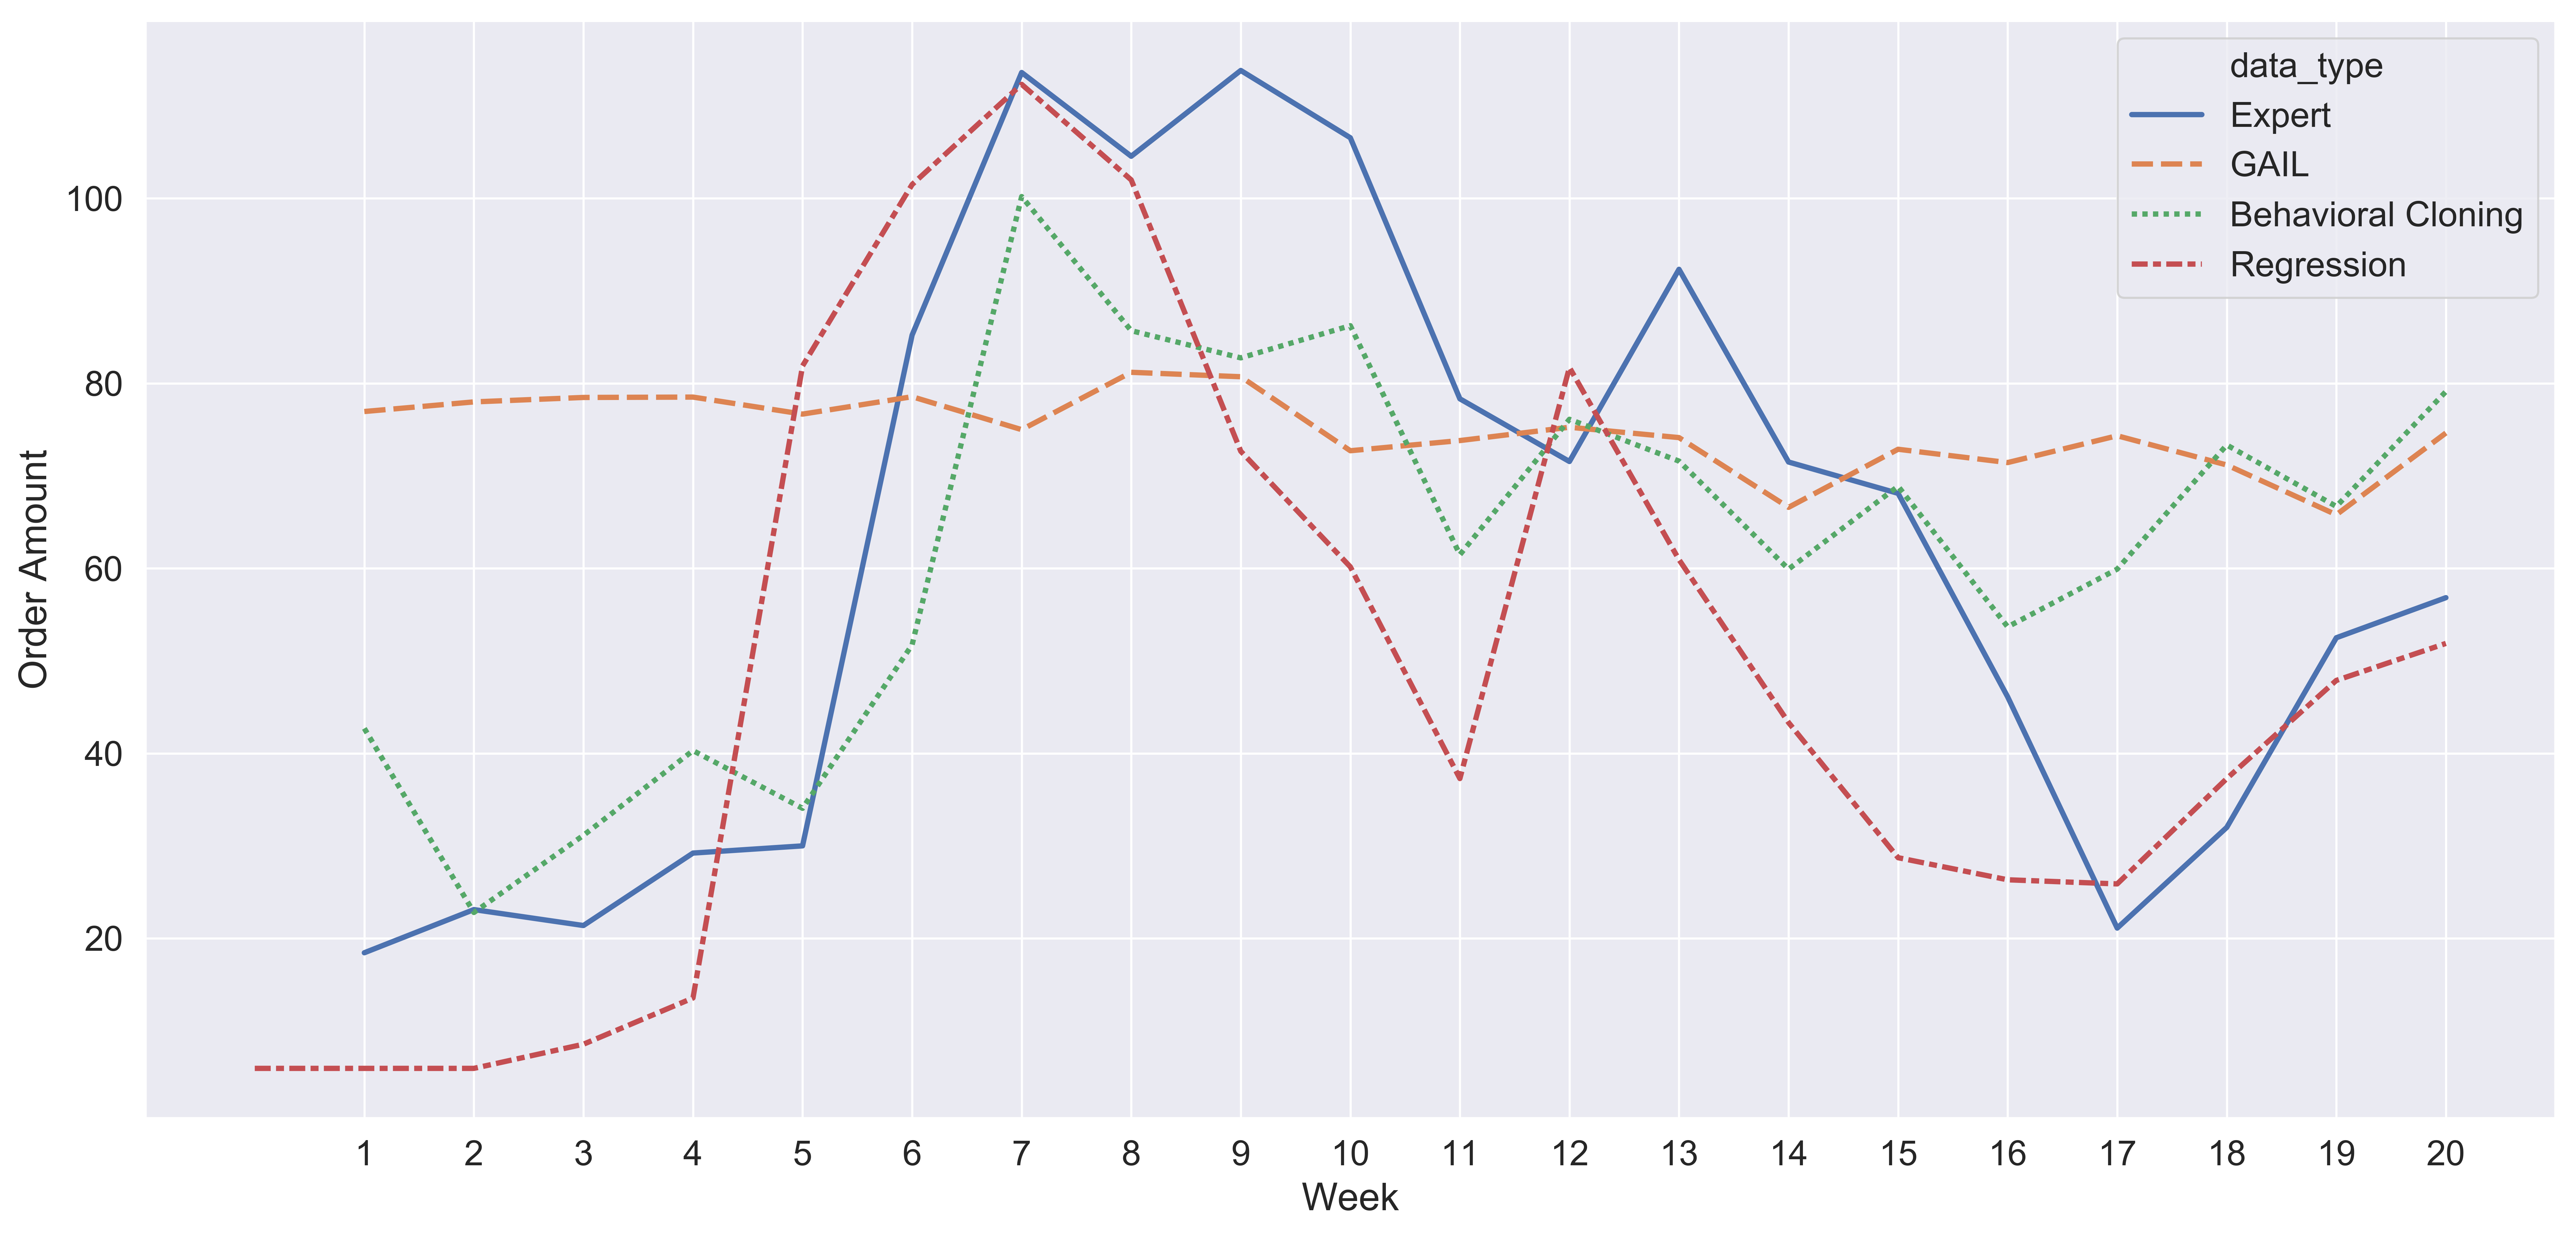

In [80]:
from ipywidgets import *

df.week = df.week.astype(int)
df.order = df.order.astype(int)

fig = plt.figure()
plt.subplots_adjust(left=0.13, right=0.97, top=0.95, bottom=0.13, wspace=0.2, hspace=0.4)
fig.set_size_inches(15, 7)
sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2, "lines.markeredgewidth": 1})
ax = sns.lineplot(x='week', y='order', hue='data_type', data=df, style='data_type', err_style=None)
ax.set(xticks=range(1, 21), ylabel='Order Amount', xlabel='Week')
plt.rcParams['figure.dpi']= 600
plt.show()

### Costs

In [71]:
print('Expert: ', int(data['episode_returns'].mean()))
print('GAIL: ', int(sum(reward_list_1) / len(reward_list_1)))
print('Behavioral Cloning: ', int(sum(reward_list_2) / len(reward_list_2)))
print('Regression: ', int(sum(reward_list_3) / len(reward_list_3)))

Expert:  -2801
GAIL:  -1043
Behavioral Cloning:  -2183
Regression:  -3694


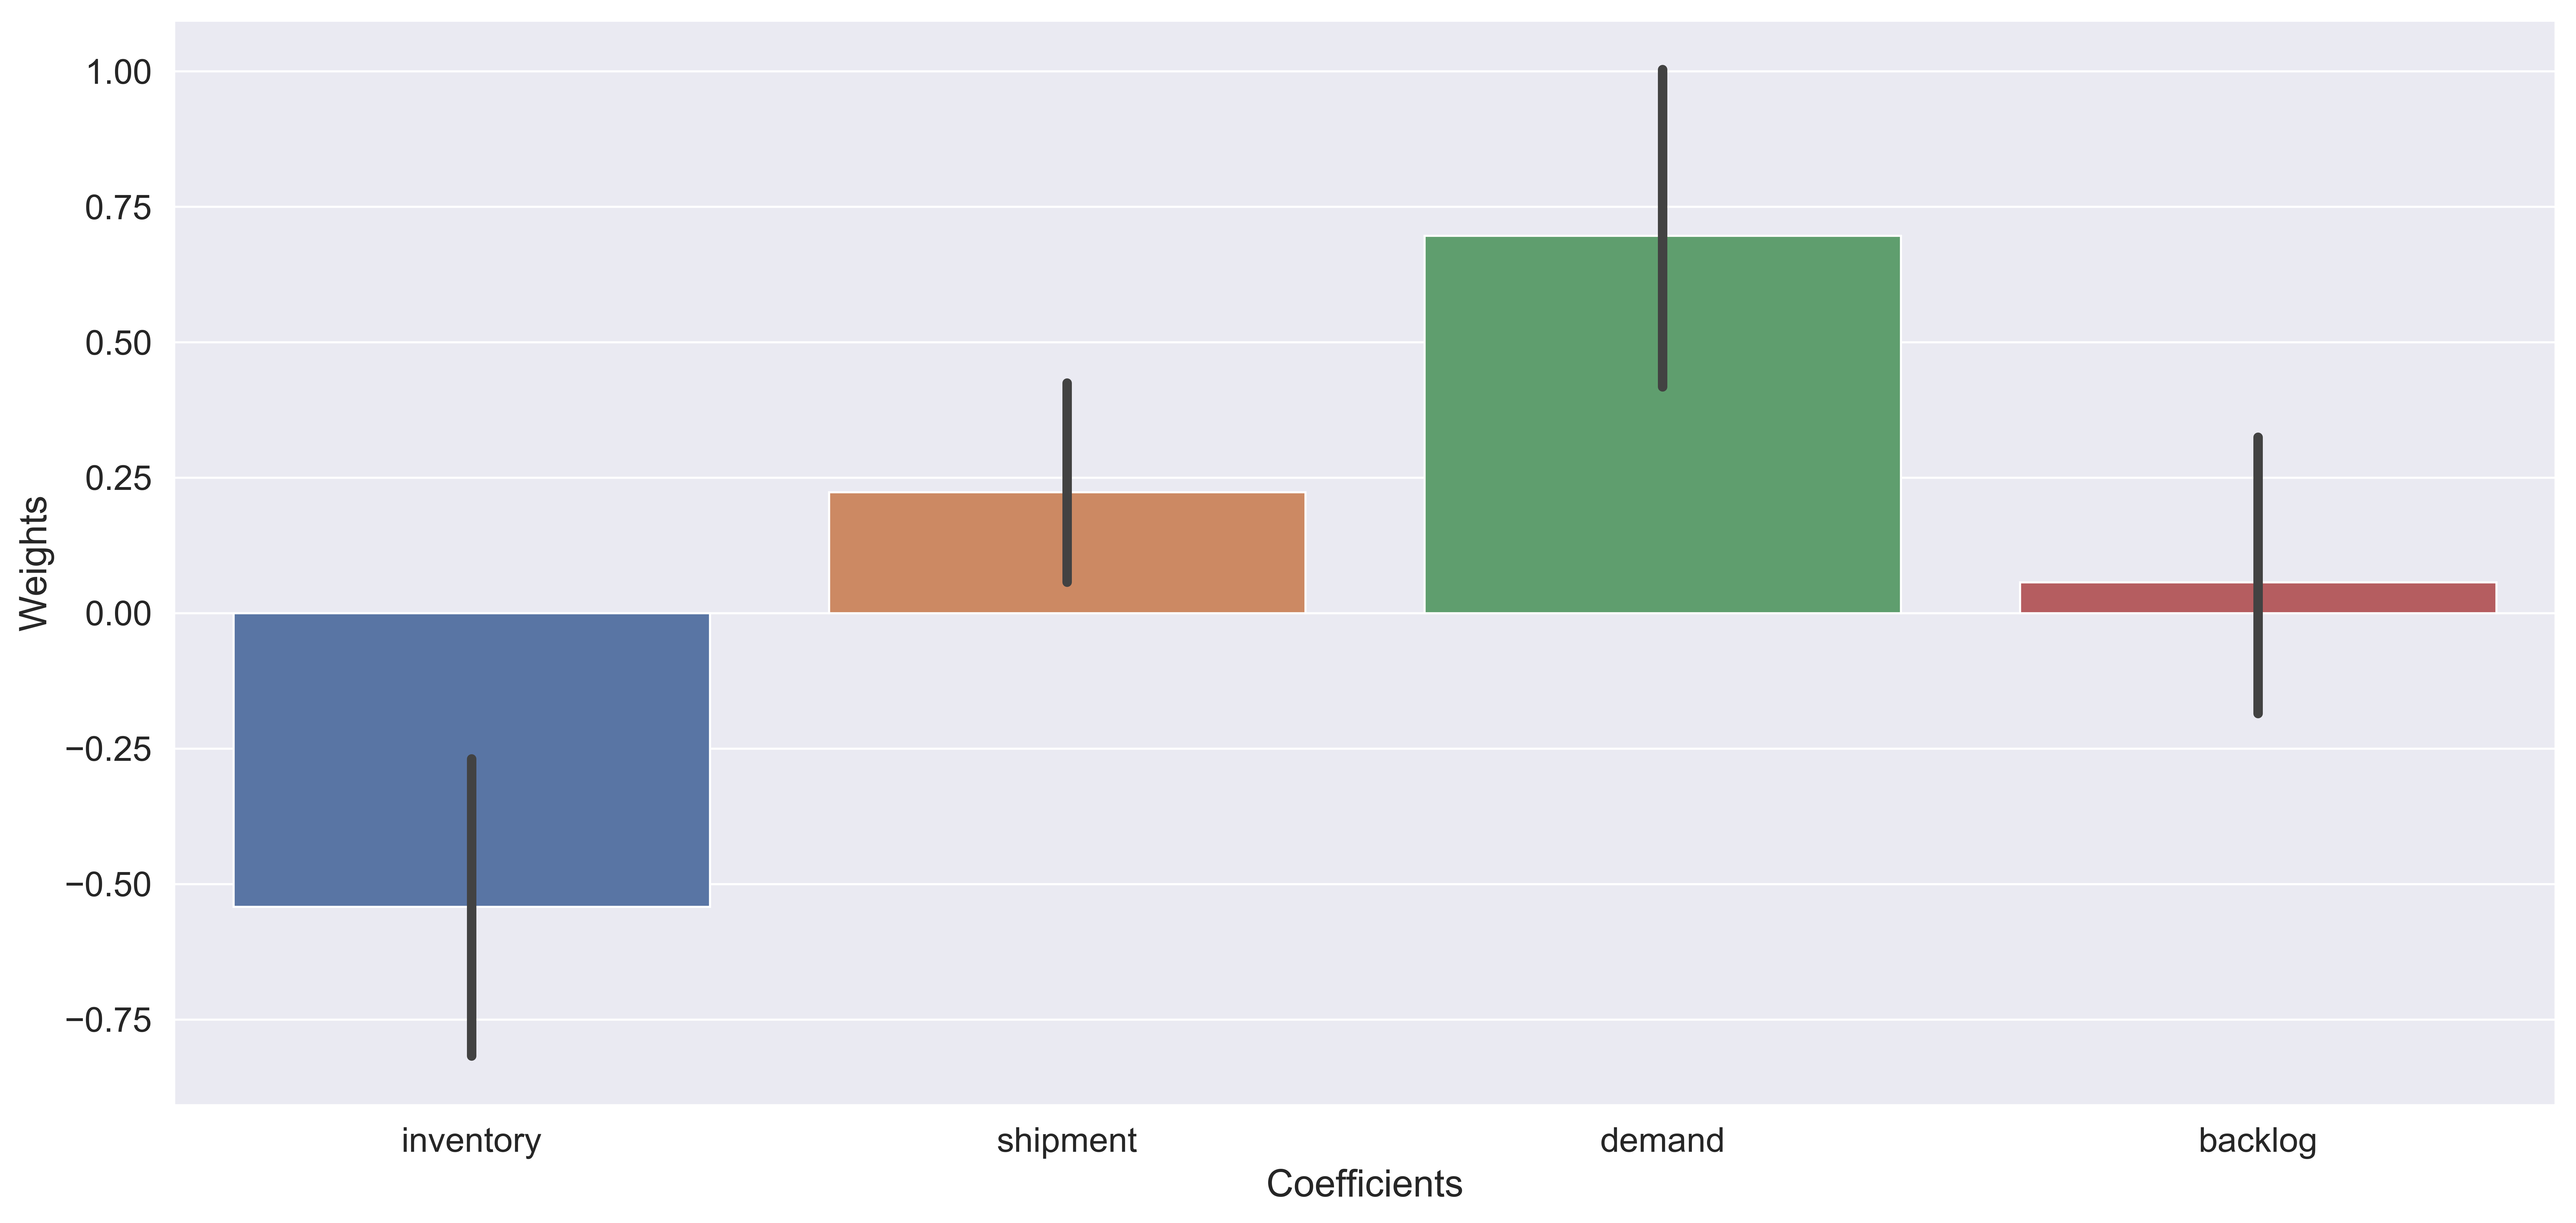

In [118]:
reg = np.zeros((0, 4))
for item in regressions:
    reg = np.append(reg, [regressions.get(item)], axis=0)
# print(reg)
# print(np.mean(reg, axis=0))
reg_df = pd.DataFrame(reg, columns=['inventory', 'shipment', 'demand', 'backlog']).melt(value_vars=['inventory', 'shipment', 'demand', 'backlog'])
# print(reg_df)
fig = plt.figure()
plt.subplots_adjust(left=0.13, right=0.97, top=0.95, bottom=0.13, wspace=0.2, hspace=0.4)
fig.set_size_inches(15, 7)
sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2, "lines.markeredgewidth": 1})
ax = sns.barplot(x='variable', y='value', data=reg_df)
# ax = sns.barplot(x='variable', y='value', data=reg_df, ci='sd')
ax.set(ylabel='Weights', xlabel='Coefficients')
plt.rcParams['figure.dpi']= 600
plt.show()

# Condition 2: Order Up-To Level without Suggestions

In [120]:
data = np.load('expert_data_2.npz')

df = pd.DataFrame(columns=['week', 'order', 'data_type'])

# players = [8, 15, 0, 17, 11, 12, 7, 2, 10, 16, 5, 6, 1, 9, 14, 13, 4, 3]
players = [0, 13, 9, 11, 15, 1, 5, 4, 14, 3, 8, 7, 2, 6, 12, 10]

i = 1
for j in range(len(data['actions'])):
    df = df.append({'week': i,
                    'order': data['actions'][j][0],
#                    'order': data['actions'][players[0] * 20 + i - 1][0],
                    'data_type': 'Expert'
                    }, ignore_index=True)
    if i == 20:
        i = 1
#         print('Expert: ', data['episode_returns'][players[0]])
#         break
    else:
        i += 1

In [121]:
model = GAIL.load('./models/with_sorted_performance/2/gail_crisp_16')

env = gym.make('Crisp-v0')
obs = env.reset()
prob = []
reward_list_1 = []
i = 1
reward_sum = 0
for j in range(1000):
    action, _states = model.predict(obs)
    df = df.append({'week': i,
                    'order': action,
                    'data_type': 'GAIL'}, ignore_index=True)
    # prob.append(model.action_probability(obs))
    obs, reward, done, info = env.step(action)
    reward_sum += reward
    i += 1
    if done:
        obs = env.reset()
        reward_list_1.append(reward_sum)
        reward_sum = 0
        i = 1
        # print('GAIL: ', reward_sum)
print('GAIL: ', sum(reward_list_1)/len(reward_list_1))

Loading a model without an environment, this model cannot be trained until it has a valid environment.


GAIL:  -1523.06


In [123]:
bc_model = GAIL.load('./models/with_sorted_performance/2/BC_crisp_16')

env = gym.make('Crisp-v0')
obs = env.reset()
prob = []
reward_list_2 = []
i = 1
reward_sum = 0
for j in range(1000):
    action, _states = bc_model.predict(obs)
    df = df.append({'week': i,
                    'order': action,
                    'data_type': 'Behavioral Cloning'}, ignore_index=True)
    # prob.append(model.action_probability(obs))
    obs, reward, done, info = env.step(action)
    reward_sum += reward
    i += 1
    if done:
        obs = env.reset()
        reward_list_2.append(reward_sum)
        reward_sum = 0
        i = 1
        # print('GAIL: ', reward_sum)
print('Behavioral Cloning: ', sum(reward_list_2) / len(reward_list_2))

Loading a model without an environment, this model cannot be trained until it has a valid environment.


Behavioral Cloning:  -2187.3


In [124]:
regressions = np.load('regression_models_2.npz')

env = gym.make('Crisp-v0')
env.seed(123)
reward_list_3 = []
for j in players[0:]:
#     if j == 8:
    weights = regressions.get(f'arr_{j}')
    obs = env.reset()
    reward_sum = 0
    for i in range(21):
        action = calculate_order(obs, *weights, method='single')
        df = df.append({'week': i,
                        'order': action,
                        'data_type': 'Regression'}, ignore_index=True)
        obs, reward, done, info = env.step(action)
        reward_sum += reward
    print('Regression: ', reward_sum)
    reward_list_3.append(reward_sum)

Regression:  -2143
Regression:  -1684
Regression:  -1951
Regression:  -1744
Regression:  -1509
Regression:  -2316
Regression:  -2172
Regression:  -2623
Regression:  -4356
Regression:  -2444
Regression:  -1867
Regression:  -2497
Regression:  -2167
Regression:  -2876
Regression:  -6652
Regression:  -2112


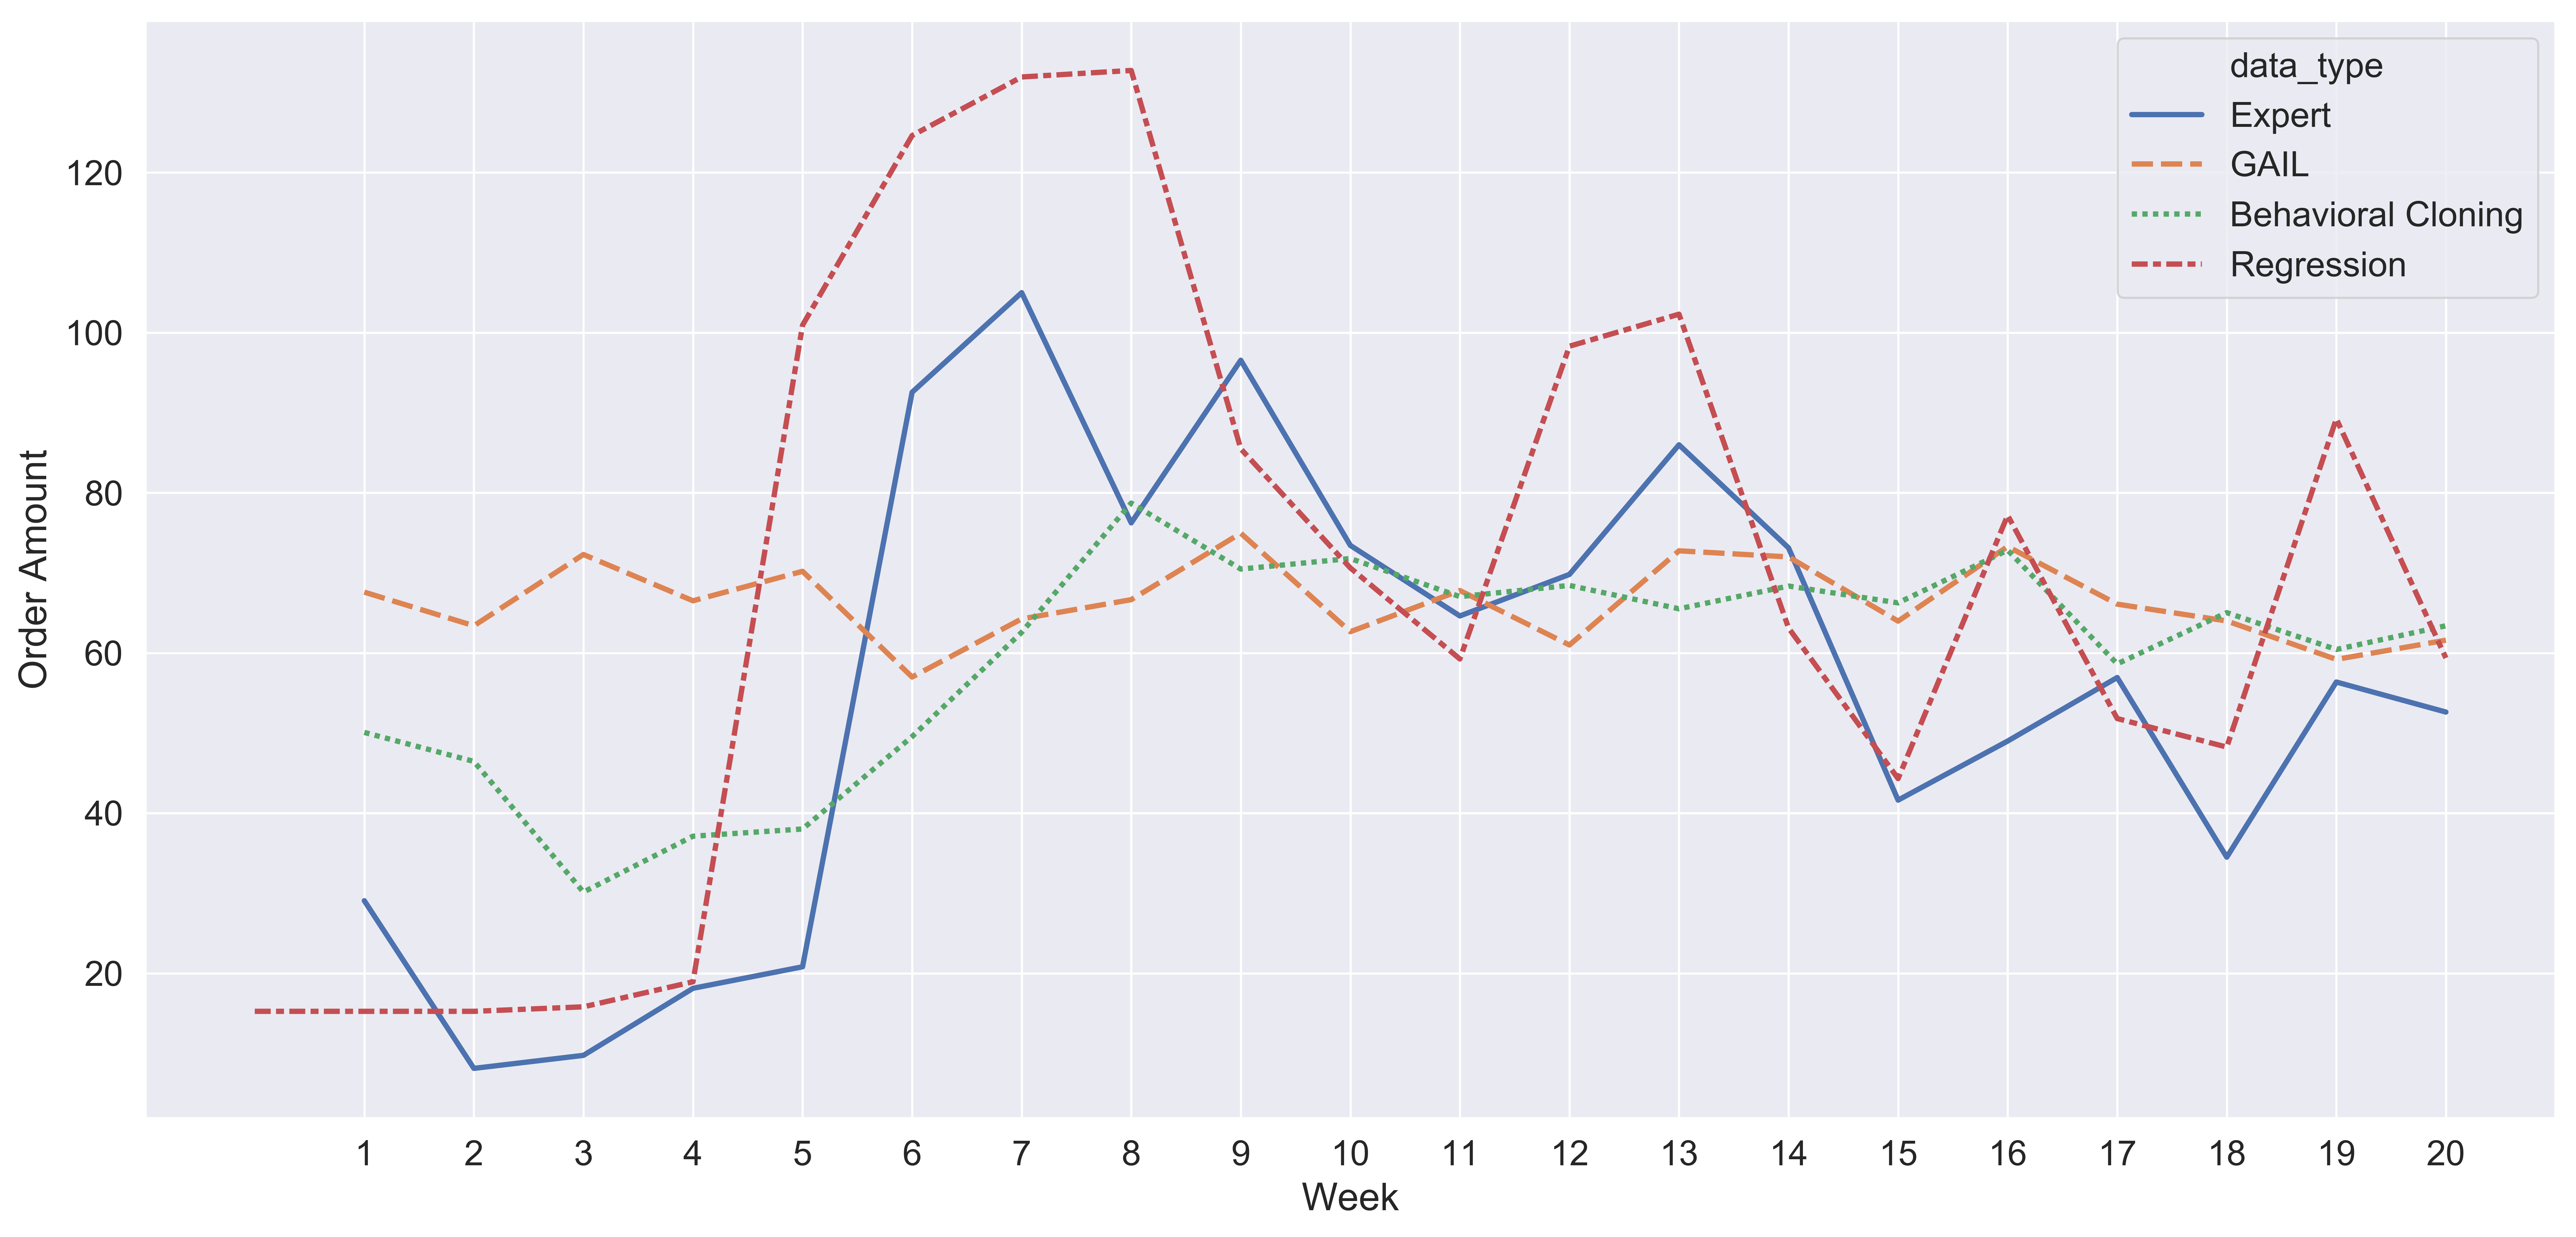

In [125]:
from ipywidgets import *

df.week = df.week.astype(int)
df.order = df.order.astype(int)

fig = plt.figure()
plt.subplots_adjust(left=0.13, right=0.97, top=0.95, bottom=0.13, wspace=0.2, hspace=0.4)
fig.set_size_inches(15, 7)
sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2, "lines.markeredgewidth": 1})
ax = sns.lineplot(x='week', y='order', hue='data_type', data=df, style='data_type', err_style=None)
ax.set(xticks=range(1, 21), ylabel='Order Amount', xlabel='Week')
plt.rcParams['figure.dpi']= 600
plt.show()

In [126]:
print('Expert: ', int(data['episode_returns'].mean()))
print('GAIL: ', int(sum(reward_list_1) / len(reward_list_1)))
print('Behavioral Cloning: ', int(sum(reward_list_2) / len(reward_list_2)))
print('Regression: ', int(sum(reward_list_3) / len(reward_list_3)))

Expert:  -1891
GAIL:  -1523
Behavioral Cloning:  -2187
Regression:  -2569


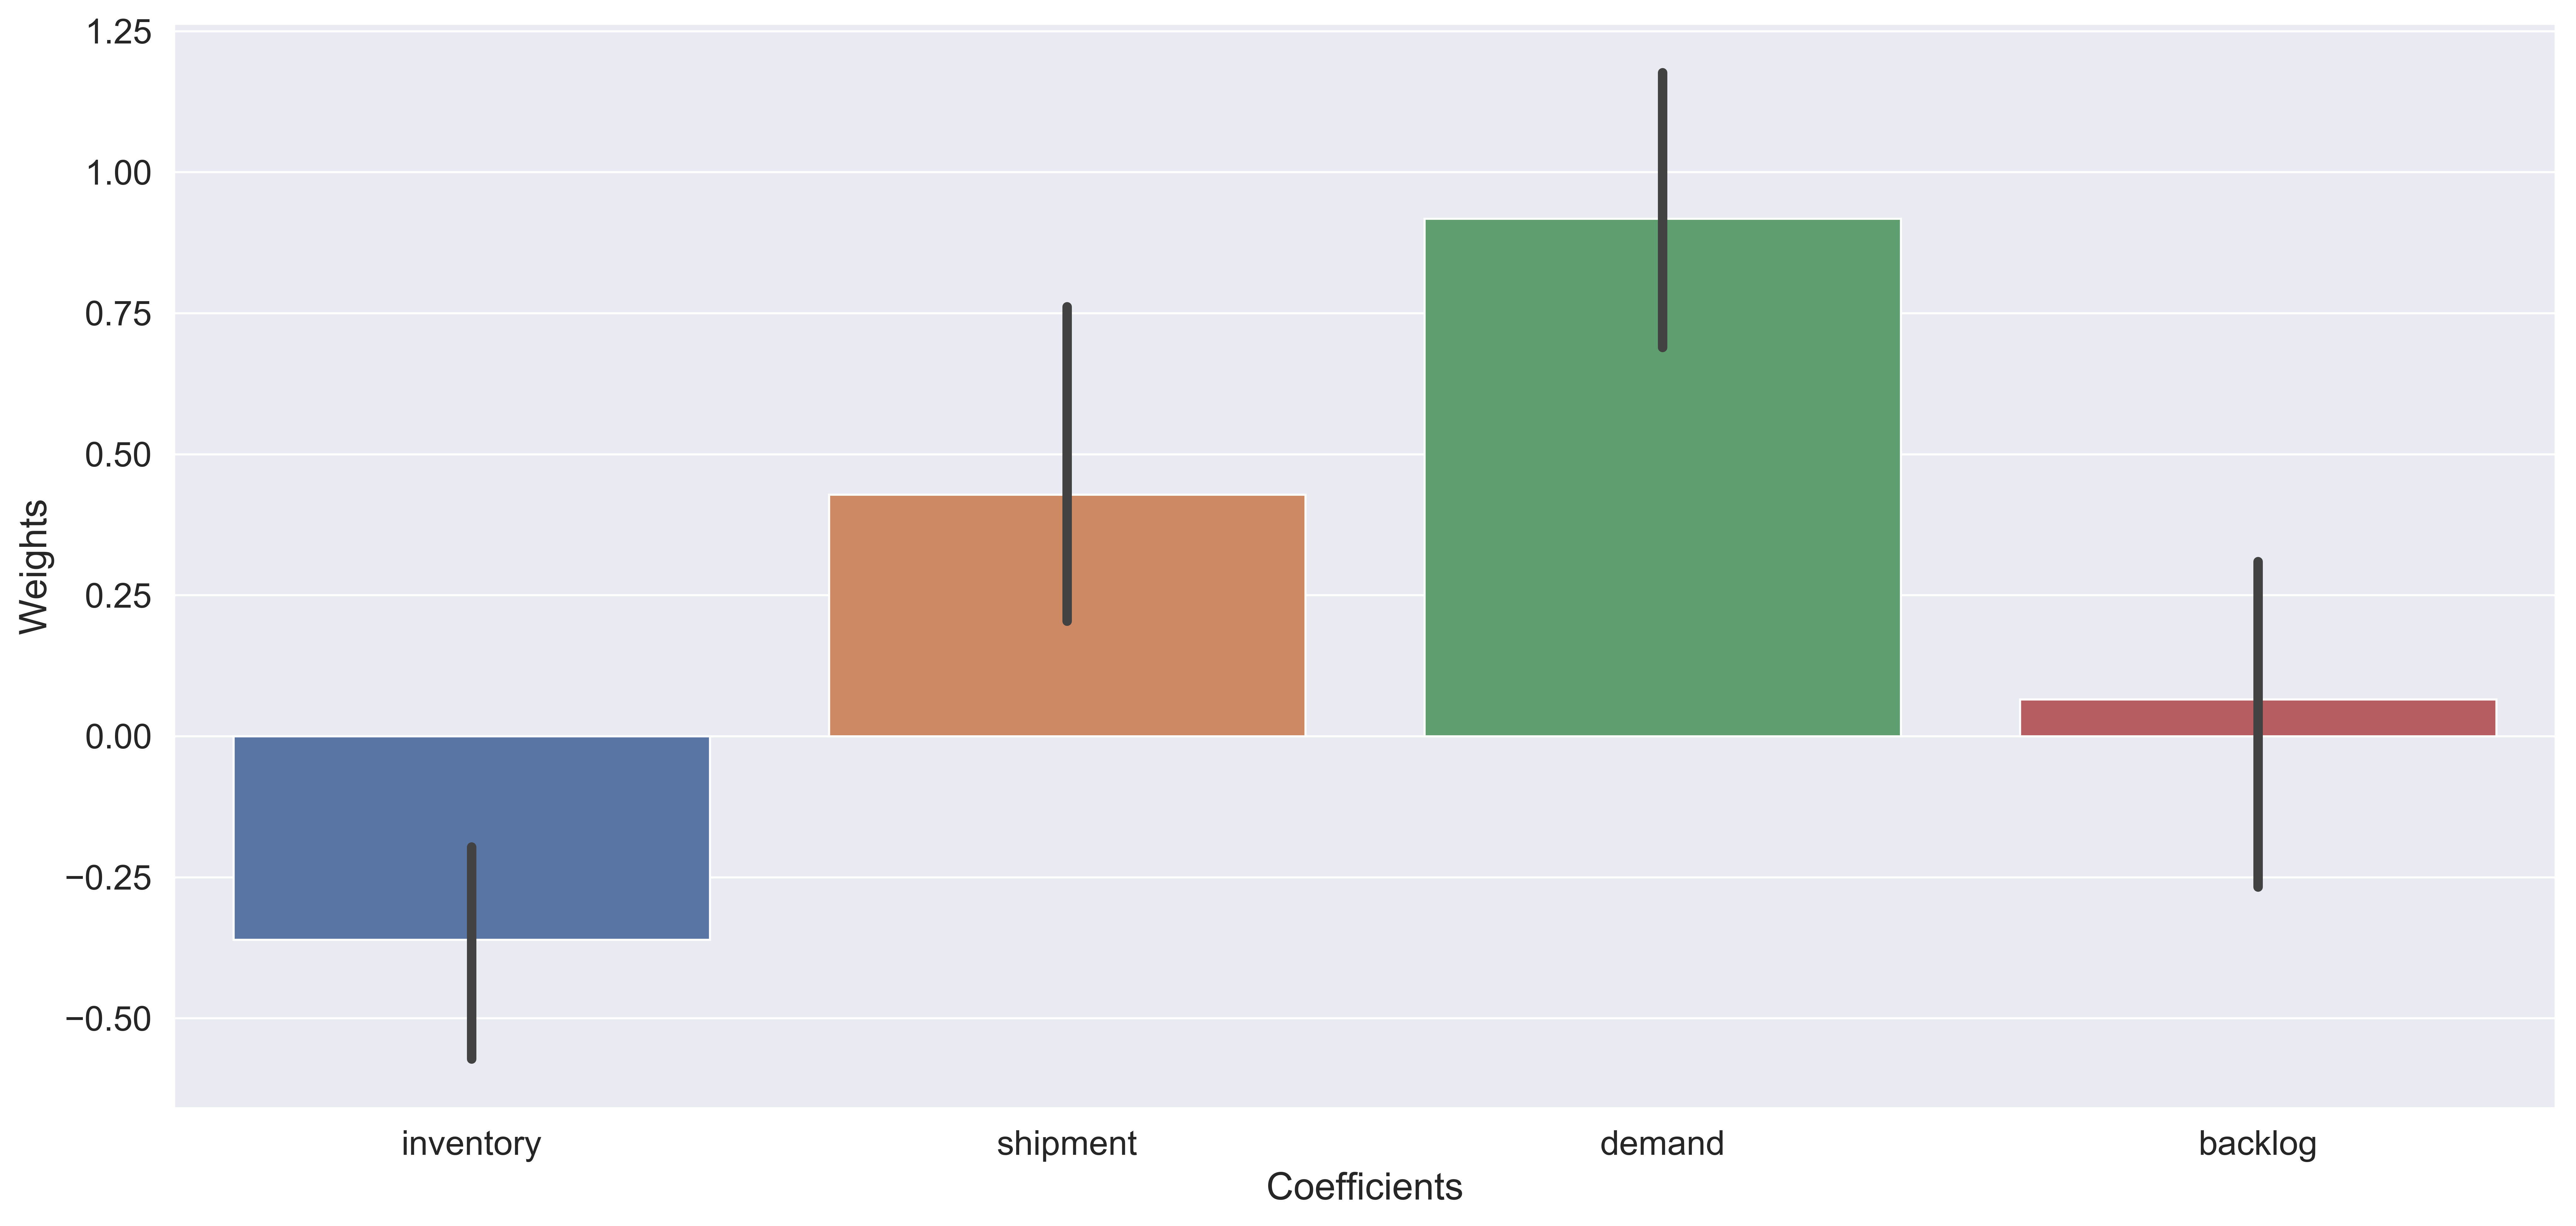

In [127]:
reg = np.zeros((0, 4))
for item in regressions:
    reg = np.append(reg, [regressions.get(item)], axis=0)
# print(reg)
# print(np.mean(reg, axis=0))
reg_df = pd.DataFrame(reg, columns=['inventory', 'shipment', 'demand', 'backlog']).melt(value_vars=['inventory', 'shipment', 'demand', 'backlog'])
# print(reg_df)
fig = plt.figure()
plt.subplots_adjust(left=0.13, right=0.97, top=0.95, bottom=0.13, wspace=0.2, hspace=0.4)
fig.set_size_inches(15, 7)
sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2, "lines.markeredgewidth": 1})
ax = sns.barplot(x='variable', y='value', data=reg_df)
# ax = sns.barplot(x='variable', y='value', data=reg_df, ci='sd')
ax.set(ylabel='Weights', xlabel='Coefficients')
plt.rcParams['figure.dpi']= 600
plt.show()

# Condition 3: Order Up-To Level with Suggestions

In [129]:
data = np.load('expert_data_3.npz')

df = pd.DataFrame(columns=['week', 'order', 'data_type'])

# players = [8, 15, 0, 17, 11, 12, 7, 2, 10, 16, 5, 6, 1, 9, 14, 13, 4, 3]
# players = [0, 13, 9, 11, 15, 1, 5, 4, 14, 3, 8, 7, 2, 6, 12, 10]
players = [9, 4, 3, 11, 10, 19, 8, 16, 12, 17, 15, 14, 13, 6, 18, 1, 7, 0, 5, 2]

i = 1
for j in range(len(data['actions'])):
    df = df.append({'week': i,
                    'order': data['actions'][j][0],
#                    'order': data['actions'][players[0] * 20 + i - 1][0],
                    'data_type': 'Expert'
                    }, ignore_index=True)
    if i == 20:
        i = 1
#         print('Expert: ', data['episode_returns'][players[0]])
#         break
    else:
        i += 1

In [130]:
model = GAIL.load('./models/with_sorted_performance/3/gail_crisp_20')

env = gym.make('Crisp-v0')
obs = env.reset()
prob = []
reward_list_1 = []
i = 1
reward_sum = 0
for j in range(1000):
    action, _states = model.predict(obs)
    df = df.append({'week': i,
                    'order': action,
                    'data_type': 'GAIL'}, ignore_index=True)
    # prob.append(model.action_probability(obs))
    obs, reward, done, info = env.step(action)
    reward_sum += reward
    i += 1
    if done:
        obs = env.reset()
        reward_list_1.append(reward_sum)
        reward_sum = 0
        i = 1
        # print('GAIL: ', reward_sum)
print('GAIL: ', sum(reward_list_1)/len(reward_list_1))

Loading a model without an environment, this model cannot be trained until it has a valid environment.


ValueError: Error: Unexpected observation shape (4,) for Box environment, please use (7,) or (n_env, 7) for the observation shape.

In [ ]:
bc_model = GAIL.load('./models/with_sorted_performance/3/BC_crisp_20')

env = gym.make('Crisp-v0')
obs = env.reset()
prob = []
reward_list_2 = []
i = 1
reward_sum = 0
for j in range(1000):
    action, _states = bc_model.predict(obs)
    df = df.append({'week': i,
                    'order': action,
                    'data_type': 'Behavioral Cloning'}, ignore_index=True)
    # prob.append(model.action_probability(obs))
    obs, reward, done, info = env.step(action)
    reward_sum += reward
    i += 1
    if done:
        obs = env.reset()
        reward_list_2.append(reward_sum)
        reward_sum = 0
        i = 1
        # print('GAIL: ', reward_sum)
print('Behavioral Cloning: ', sum(reward_list_2) / len(reward_list_2))

In [ ]:
regressions = np.load('regression_models_3.npz')

env = gym.make('Crisp-v0')
env.seed(123)
reward_list_3 = []
for j in players[0:]:
#     if j == 8:
    weights = regressions.get(f'arr_{j}')
    obs = env.reset()
    reward_sum = 0
    for i in range(21):
        action = calculate_order_2(obs, *weights, method='single')
        df = df.append({'week': i,
                        'order': action,
                        'data_type': 'Regression'}, ignore_index=True)
        obs, reward, done, info = env.step(action)
        reward_sum += reward
    print('Regression: ', reward_sum)
    reward_list_3.append(reward_sum)

In [ ]:
from ipywidgets import *

df.week = df.week.astype(int)
df.order = df.order.astype(int)

fig = plt.figure()
plt.subplots_adjust(left=0.13, right=0.97, top=0.95, bottom=0.13, wspace=0.2, hspace=0.4)
fig.set_size_inches(15, 7)
sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2, "lines.markeredgewidth": 1})
ax = sns.lineplot(x='week', y='order', hue='data_type', data=df, style='data_type', err_style=None)
ax.set(xticks=range(1, 21), ylabel='Order Amount', xlabel='Week')
plt.rcParams['figure.dpi']= 600
plt.show()

In [ ]:
print('Expert: ', int(data['episode_returns'].mean()))
print('GAIL: ', int(sum(reward_list_1) / len(reward_list_1)))
print('Behavioral Cloning: ', int(sum(reward_list_2) / len(reward_list_2)))
print('Regression: ', int(sum(reward_list_3) / len(reward_list_3)))

In [ ]:
reg = np.zeros((0, 7))
for item in regressions:
    reg = np.append(reg, [regressions.get(item)], axis=0)
# print(reg)
# print(np.mean(reg, axis=0))
reg_df = pd.DataFrame(reg, columns=['inventory', 'shipment', 'demand', 'backlog', 
                                    'upToLevel', 'onOrder', 'suggested']).melt(
    value_vars=['inventory', 'shipment', 'demand', 'backlog', 'upToLevel', 'onOrder', 'suggested'])
# print(reg_df)
fig = plt.figure()
plt.subplots_adjust(left=0.13, right=0.97, top=0.95, bottom=0.13, wspace=0.2, hspace=0.4)
fig.set_size_inches(15, 7)
sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2, "lines.markeredgewidth": 1})
ax = sns.barplot(x='variable', y='value', data=reg_df)
# ax = sns.barplot(x='variable', y='value', data=reg_df, ci='sd')
ax.set(ylabel='Weights', xlabel='Coefficients')
plt.rcParams['figure.dpi']= 600
plt.show()